# Including

In [2]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb"; regex=r"#.*executeme")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb");

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [3]:
Nx=8
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = Nx*Ny
PN = 1
U=2;

# Sub Space Kinetic Term

In [4]:
sp_basis = NLevelBasis(N)
periodicity = 0 #periodic (select 1 for hard-wall conditions)
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [5]:
H1 = get_sp_op(sp_basis, sp_matrix);

In [6]:
#eigenenergies(dense(H1)) == eigvals(sp_matrix) #true
eigenenergies(dense(H1));

In [7]:
sub_states = get_sub_states(H1, cut_off);

In [8]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [9]:
H1_sub = get_subspace_op(H1, P, Pt);

In [10]:
H1_sub.basis_l

Subspace(superbasis=NLevel(N=80), states:80)

In [11]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

In [12]:
# ALTERNATIVE FOR CONSTRUCTING THE INTERACTION TERM

In [13]:
# H1M = H1.data;

In [14]:
# P1 = P.data
# P1t = Pt.data;

In [15]:
# @einsum H1_tildeM[i,j] := P1[i,k] * H1M[k,l] * P1t[l,j];

In [16]:
# H1_tilde = Operator(basis_sub, H1_tildeM);

In [17]:
# m = 1
# V2 = U/2 * transition(sp_basis,m,m)⊗transition(sp_basis,m,m)
# for m in 2:N
#     V2 += U/2 * transition(sp_basis,m,m)⊗transition(sp_basis,m,m)
# end

In [18]:
# V2M = V2.data;

In [19]:
# P2M = (P⊗P).data
# P2_dagM = (Pt⊗Pt).data;

In [20]:
# @einsum V2_tildeM[i2,j2] := P2M[i2,k2] * V2M[k2,l2] * P2_dagM[l2,j2];

In [21]:
# V2_tilde = Operator(basis_sub, V2_tildeM);

In [22]:
PN

1

In [23]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [24]:
H1_MB = get_mb_op(basis_mb, H1_sub);

In [25]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [26]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

In [27]:
H_Kin = SparseOperator(basis_cut_mb)
H_Kin.data = H1_MB.data;

# Sub Space Hubbard Interaction Term

In [109]:
# H_Int = Hubbard_Interaction(P, Pt, basis_cut_mb, cut_off, U);

In [29]:
H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U);

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
12.5%┣█████▍                                     ┫ 1/8 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 22it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 22it/s]


In [137]:
# H_NI_tilde_mb = manybodyoperator(basis_mb, H1_tilde);

# Vint_tilde_mb = manybodyoperator(basis_mb, V2_tilde);

# H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;

# H_tilde_mb = (H_tilde_mb + H_tilde_mb')/2;

In [139]:
Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub);

0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 59.2kit/s]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 40.8kit/s]


In [140]:
Total_H = H_Kin + H_Int;

# Total Hamiltonian with Impurity Potential

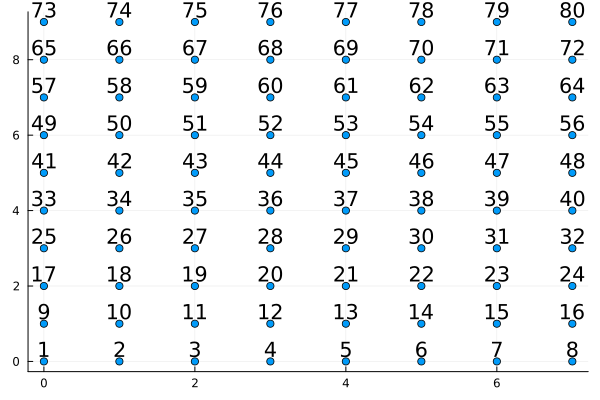

In [141]:
plot_square_lattice(Nx, Ny)

In [142]:
V0 = [4, 0]; Imp_Site = [51, 1]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([4.0, 0.0], [51, 1])

In [143]:
H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
H_Impurity = dense((H_Impurity'+H_Impurity)/2);

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [ ]:
E, V = eigenstates(H_Impurity);

In [145]:
pn = maximum(PN)
filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb);

In [146]:
N_Pin = 1
nu0 = 1/2
NPhi0 = Nx*Ny*(p/q)
NPhi = NPhi0-N_Pin
N_d = Int(NPhi - pn/nu0)
Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))

7

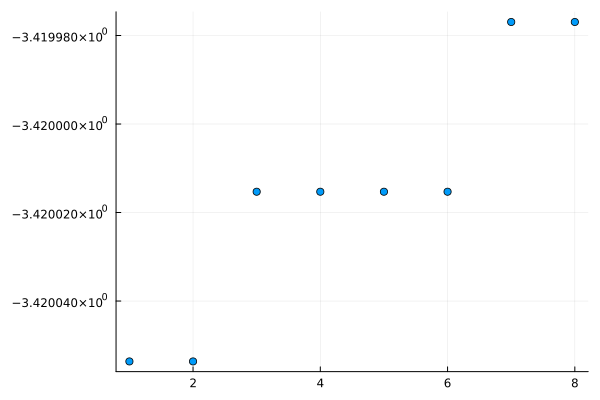

In [147]:
scatter(filtered_energies, legend=false)

In [148]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [149]:
r_hubbard_states = Restricted_Hubbard_States(V);

# Density Profile

In [198]:
Sub_Number_MB_Operator_List[1]

Operator(dim=8x8)
  basis: ManyBody(onebodybasis=NLevel(N=8), states:8)sparse(Int64[], Int64[], ComplexF64[], 8, 8)

In [199]:
r_hubbard_states[1]

Ket(dim=8)
  basis: ManyBody(onebodybasis=NLevel(N=8), states:8)
   0.407912663812484 + 0.9128084209088094im
 0.01049083535380997 + 0.01667296593137807im
        -1.35399e-12 - 2.93312e-12im
           5.738e-12 - 3.33739e-12im
         5.49244e-12 + 4.25354e-12im
        2.671789e-11 - 3.47113e-12im
         9.90989e-12 + 1.892701e-11im
         1.70996e-12 - 0.0im

In [151]:
expect(Sub_Number_MB_Operator_List[1],r_hubbard_states[1])

0.0 + 0.0im

In [99]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

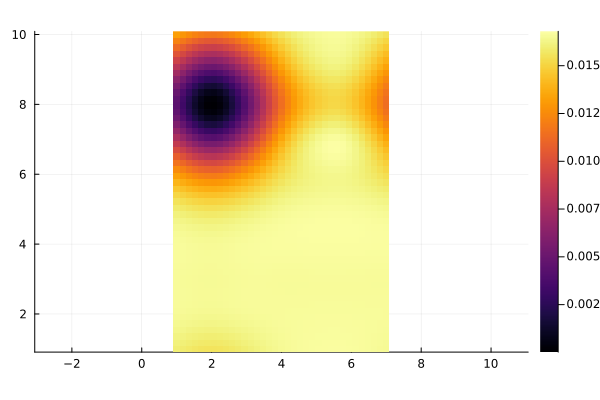

In [100]:
data = avg_density'
factor = 5

Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

# Torus Distance and Equivalent (Periodic) Sites

In [41]:
@nbinclude("Torus_Distance.ipynb");

In [42]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 36 # Site Pinned (Site 44 = Site 36) # BURASI GENEL DEĞİL SORUN YARATABİLİR!!!
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [43]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

# Density Plot and $Q_{\rho}$ Calculation

In [44]:
# # Density Plot
# index_eig_states = 1
# Plots.heatmap(Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)', colormap=:dense)

# # koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
# x_coordinates = coordinates[:,1] .+1
# y_coordinates = coordinates[:,2] .+1
# Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# # Site Index
# for i in 1:N
#     p = Plots.annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
# end

# # Circle
# function circle_shape(h,k,r)
#     beta = reverse(LinRange(0, 2*pi, 500))
#     h .+ r*sin.(beta), k .+ r*cos.(beta)
# end

# # Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
# center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1
# Plots.plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

# p

In [45]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

LoadError: UndefVarError: `x_co` not defined

In [46]:
radius_list

17-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 5.0
 5.0990195135927845
 5.385164807134504
 5.830951894845301

In [47]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [48]:
depletion_prof = get_depletion_profile(radius_list, avg_density)
#Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
# Q = pn/NPhi
# g(x)=Q; x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

17-element Vector{Any}:
 0.004301068196870227
 0.027217021017986884
 0.0561857587902977
 0.08957497216980874
 0.1692281891462068
 0.2200304439444529
 0.24954651306063208
 0.3211200397149876
 0.4130998736985483
 0.4164141016127515
 0.4267734310058875
 0.4669310201880079
 0.48231191046314775
 0.49710764475999275
 0.49710764475999275
 0.4986923508984509
 0.4999999999999996

# Berry Matrix

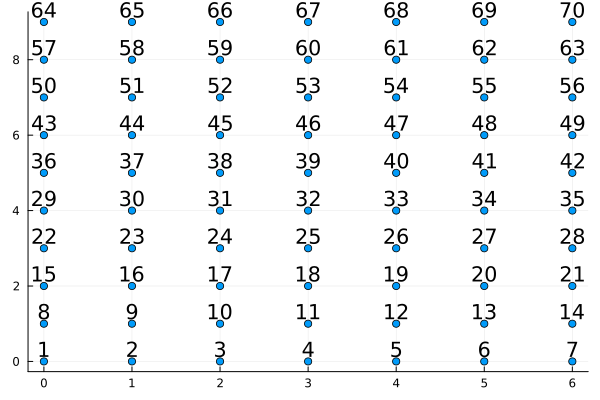

In [101]:
plot_square_lattice(Nx, Ny)

In [178]:
start_point_1 = Impurity_Data.Imp_Site[1]
start_point_1 = 17

17

In [179]:
lens_1 = [5, 5, 5, 5]
dirs_1 = [1, -Nx, -1, Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = [45,46,47,48,41,34,27,26,25,24,31,38,45]
rec_path_1 = [45,46,39,38]
rec_path_1 = [51,44,37,30,23,16,17,18,25,32,39,46,53,52,51]
rec_path_1 = [17,19,47,45]

4-element Vector{Int64}:
 17
 19
 47
 45

In [181]:
start_point_2 = Impurity_Data.Imp_Site[2]
start_point_2 = [1]

1-element Vector{Int64}:
 1

In [184]:
lens_2 = [4, 8]
dirs_2 = [-1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2=rec_path_1
# i = 38
# rec_path_2 = [ 38 for i in 1:9 ]
rec_path_2 = rec_path_1

4-element Vector{Int64}:
 17
 19
 47
 45

In [106]:
N_Pin = 4
V1 = Impurity_Data.V0[1]
V2 = Impurity_Data.V0[2]

0.0

In [107]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([4.0, 0.0, 0.0, 0.0], [51, 44, 51, 44])

In [108]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [109]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...)

8×6 Matrix{ComplexF64}:
          0.0+0.0im         …           0.0+0.0im
     0.955139+0.288846im       -2.94879e-12-1.6996e-12im
  -0.00255381+0.00191168im     -6.75252e-11-7.5036e-12im
    0.0472292+0.0432484im       4.32357e-12+1.48286e-12im
 -0.000302548-0.00085529im     -7.37991e-11-4.68958e-12im
   -0.0097915+0.00610967im  …  -2.80911e-11+1.24719e-11im
   0.00272967-0.00481303im        0.0978855-0.172594im
  -0.00112017-0.0im                0.980117+0.0im

In [110]:
U_first = copy(U_Imp_0);

In [111]:
delta_t = 0.0015
STEP = 0:delta_t:1
length(STEP)

667

In [112]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [113]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [114]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                            ┫ 0/9.3k [00:00<-6:-29, -0s/it]
0.0%┣                                         ┫ 1/9.3k [00:00<Inf:Inf, InfGs/it]
24.0%┣█████████                             ┫ 2.2k/9.3k [00:00<00:01, 12.8kit/s]
58.4%┣██████████████████████▏               ┫ 5.5k/9.3k [00:00<00:00, 23.6kit/s]
100.0%┣█████████████████████████████████████┫ 9.3k/9.3k [00:00<00:00, 33.1kit/s]
100.0%┣█████████████████████████████████████┫ 9.3k/9.3k [00:00<00:00, 32.9kit/s]


In [115]:
function U_Imp_0_Ket()
    Eigen_List = []
    U_IMP_0_List = []
    for Impurity_HH in ProgressBar(Impurity_H_List)
        Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
        E_Imp, U_Imp = eigenstates(Impurity_HH)
        push!(Eigen_List, U_Imp)
        U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
        A = U_Imp_0'*U_Imp
        A_inv = inv(A)
        U_Imp_0 = U_Imp*transpose(A_inv)
        global U_Imp_0 = gram_schmidt(U_Imp_0)
    end
    return U_Imp_0, Eigen_List, U_IMP_0_List
end

U_Imp_0_Ket (generic function with 1 method)

In [116]:
U_Imp_0, Eigen_List, U_IMP_0_List = U_Imp_0_Ket();
U_Imp_0

0.0%┣                                             ┫ 0/9.3k [00:00<00:00, -0s/it]
0.0%┣                                         ┫ 1/9.3k [00:00<Inf:Inf, InfGs/it]
3.7%┣█▌                                       ┫ 344/9.3k [00:00<00:04, 2.2kit/s]
10.6%┣████▎                                   ┫ 994/9.3k [00:00<00:02, 4.7kit/s]
13.7%┣█████▎                                 ┫ 1.3k/9.3k [00:00<00:02, 4.8kit/s]
21.8%┣████████▌                              ┫ 2.0k/9.3k [00:00<00:01, 6.5kit/s]
25.9%┣██████████▏                            ┫ 2.4k/9.3k [00:00<00:01, 6.6kit/s]
32.4%┣████████████▋                          ┫ 3.0k/9.3k [00:00<00:01, 7.2kit/s]
39.2%┣███████████████▎                       ┫ 3.7k/9.3k [00:00<00:01, 7.8kit/s]
46.0%┣██████████████████                     ┫ 4.3k/9.3k [00:01<00:01, 8.2kit/s]
49.5%┣███████████████████▎                   ┫ 4.6k/9.3k [00:01<00:01, 8.0kit/s]
57.7%┣██████████████████████▌                ┫ 5.4k/9.3k [00:01<00:00, 8.6kit/s]
62.8%┣██████████████████████

8×6 Matrix{ComplexF64}:
         0.0+0.0im               0.0+0.0im         …         0.0+0.0im
    0.104818-0.105548im   -0.0557613-0.0438727im       -0.101718+0.390739im
    0.177793+0.786148im   0.00682636+0.00280166im      -0.203341-0.231531im
  -0.0510776-0.0357688im   -0.474692+0.209701im         -0.19108-0.0515782im
  -0.0612375-0.501366im    0.0478209+0.119429im         -0.30206-0.288018im
 -0.00955952-0.143333im     0.217018+0.550972im    …  -0.0283238-0.149177im
  -0.0344901-0.209356im   -0.0585199-0.494152im        -0.152201-0.46973im
   0.0543487+0.0248701im     0.32525+0.0706289im       -0.502916-0.0941524im

In [117]:
U_Imp_0 == U_first

false

In [118]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
angle.(BerryEnergies)/pi

6-element Vector{Float64}:
  0.853019090417304
 -0.8366541394880467
 -0.6222117792192692
  0.5192826520790071
  0.16100636321801876
 -0.08171089416506161

In [68]:
# data1 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[1])'
# data2 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[185])'

In [69]:
# Plots.heatmap(Interp(data1, factor), aspect_ratio=:equal)

In [70]:
# Plots.heatmap(Interp(data2, factor), aspect_ratio=:equal)

# Single Particle Brading

In [68]:
co[20,:]

2-element Vector{Int64}:
 3
 2

In [145]:
x0, y0 = [2,2]
x1, y1 = [4,2]
x2, y2 = [4,6]
x3, y3 = [2,6]

2-element Vector{Int64}:
 2
 6

In [146]:
co = vcat( ( [y x] for x in 0:Ny-1 for y in 0:Nx-1 ) ... );

In [147]:
cut_off

80

In [162]:
U_pot = 10
Wid_pot = 1
pos = [2.3, 5.1]
imp = [impurity(U_pot, pos, Wid_pot)]

1-element Vector{impurity}:
 impurity(10.0, [2.3, 5.1], 1.0)

In [163]:
VVV, basis_sub, P, Pt = Vpin2(imp[1], Nx, Ny, cut_off, sp_basis, co);

In [164]:
Total_H_sp = H_Kin + VVV
Total_H_sp = (Total_H_sp' + Total_H_sp)/2;

In [165]:
E_sp, V_sp = eigenstates(dense(Total_H_sp));

In [166]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

In [167]:
# cut_sp_basis
number_sp_list = [Operator(basis_cut_mb, num_sub_list[i].data) for i in ProgressBar(1:N)]
number_mb_list = [get_mb_op(basis_cut_mb, number_sp_list[i]) for i in 1:N];

0.0%┣                                               ┫ 0/80 [00:00<00:-2, -0s/it]
1.2%┣▌                                          ┫ 1/80 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 80/80 [00:00<00:00, 836it/s]
100.0%┣███████████████████████████████████████████┫ 80/80 [00:00<00:00, 826it/s]


In [168]:
Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub);

0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 56.0kit/s]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 25.5kit/s]


In [169]:
avg_density = Get_Avg_Density(Nx, Ny, 1, N, Sub_Number_MB_Operator_List, basis_cut_mb, V_sp)

8×10 Matrix{Float64}:
 8.1687e-33   1.2495e-33   2.13248e-34  …  3.35472e-32  3.57329e-34
 4.94883e-34  6.82367e-34  2.8385e-32      3.17109e-33  2.62422e-34
 1.09837e-31  2.6344e-33   5.13675e-33     4.89451e-34  3.73561e-33
 9.2234e-34   7.13904e-34  1.8245e-32      2.81246e-34  5.93295e-35
 2.36669e-32  1.00132e-33  1.71721e-32     1.9845e-33   2.28271e-33
 1.12843e-31  3.18668e-34  5.24521e-34  …  2.47832e-33  8.45232e-35
 3.24882e-32  6.62815e-33  1.51687e-33     1.53738e-34  3.25443e-33
 0.0          7.1253e-34   1.7755e-32      7.94752e-34  2.13954e-32

In [170]:
avg_density[pos[1]+1,pos[2]+1]

LoadError: ArgumentError: invalid index: 3.3 of type Float64

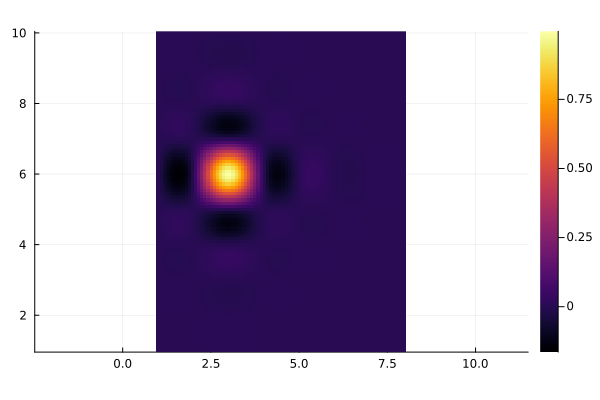

In [174]:
data = avg_density'
factor = 10

Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)

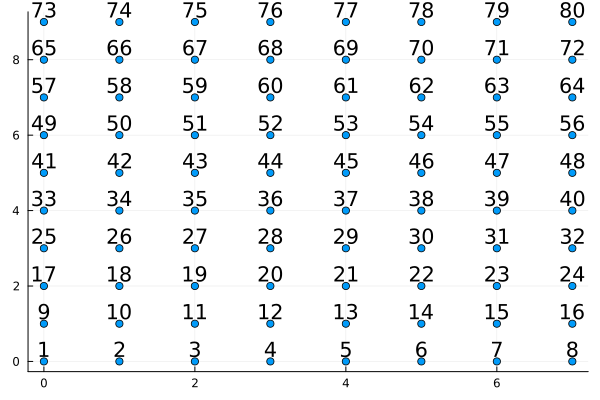

In [158]:
plot_square_lattice(Nx, Ny)

In [159]:
A = 1
step=0.1;

In [160]:
θ, ψ = get_ab_phase2(x0,y0,x1,y1,x2,y2,x3,y3,step,Wid_pot,U_pot,A,V_sp,Nx, Ny, cut_off,sp_basis,co,H_Kin)
θ

-5.74266817486468e-17

In [194]:
avg_density = Get_Avg_Density(Nx, Ny, 1, N, Sub_Number_MB_Operator_List, basis_cut_mb, ψ[55])
avg_density_2 = Get_Avg_Density(Nx, Ny, 1, N, Sub_Number_MB_Operator_List, basis_cut_mb, ψ[5])
isapprox(avg_density,avg_density_2)

true

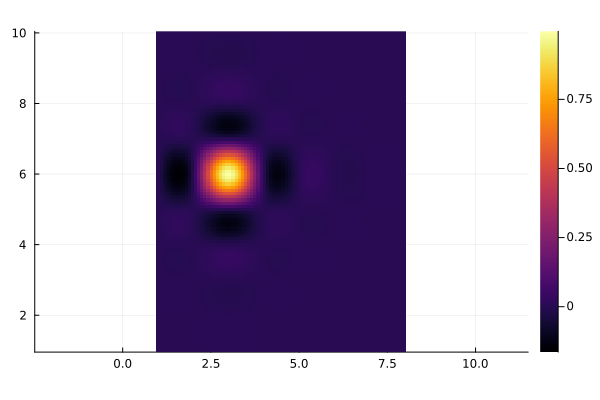

In [193]:
data = avg_density'
factor = 10

Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)